# Demo project - Wine quality prediction

## Contents:
* [Import packages](#first-bullet)
* [Load Data](#second-bullet)
* [Exploratory data analysis](#third-bullet)
* [Prepare dataset for training model](#forth-bullet)
* [Build a baseline model](#fifth-bullet)
* [Experiment with a new model](#sixth-bullet)
* [Predict](#seventh-bullet)

## Import packages <a class="anchor" id="first-bullet"></a>

In addition to the s3fs package, we will need to import hyperopt, cloudpickle, mlflow, and xgboost<br>
Modify the following cell to make this happen<br>

In [104]:
!pip install s3fs
# Install more modules that you need here
!pip install seaborn
!pip install mlflow


[notice] A new release of pip available: 22.2.2 -> 24.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 231.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 240.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 272.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 292.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 252.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 295.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 326.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 274.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 283.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [105]:
import pandas
# Import more modules and classes that you need here - REMEMBER TO RERUN THE CELL AFTER MODIFYING!
import os
import seaborn
import matplotlib.pyplot
import sklearn.model_selection
import mlflow

## Load Data <a class="anchor" id="second-bullet"></a>

You have access to a Minio-based S3 storage where your datasets are available, and where you will eventually push models. This storage is defined using a 'Data Connection' in your Data Science Project. You can access this data connection using environment variables. Run the following shell block to determine the environment variable names:


In [9]:
!env | grep AWS

AWS_S3_ENDPOINT=http://minio-service.madgrape.svc.cluster.local:9000
AWS_DEFAULT_REGION=eu-central-1
AWS_SECRET_ACCESS_KEY=Docl0jG66ycAueZ16ilaUdBbSTjJHPZDLWHoN0Tl
AWS_S3_BUCKET=data
AWS_ACCESS_KEY_ID=NOmxShltGAD8oB2Pv0Y2


You will need to assign these to Python variables to be able to use them in code blocks. We've started you off with some code below, but you'll also need variables set for the endpoint and bucket. Remember to import modules as needed in the import block at the top of the Notebook and re-run the cell below again after importing any modules.


In [10]:
AWS_ACCESS_KEY_ID = os.environ['AWS_ACCESS_KEY_ID']
AWS_SECRET_ACCESS_KEY = os.environ['AWS_SECRET_ACCESS_KEY']
# Add variable assignments for AWS_S3_ENDPOINT and AWS_S3_Bucket below.
AWS_S3_ENDPOINT = os.environ['AWS_S3_ENDPOINT']
AWS_S3_BUCKET = os.environ['AWS_S3_BUCKET']

Check that your variables have been correctly set:


In [11]:
print("AWS_ACCESS_KEY is " + AWS_ACCESS_KEY_ID)
print("AWS_SECRET_ACCESS_KEY is " + AWS_SECRET_ACCESS_KEY)
print("AWS_S3_ENDPOINT is " + AWS_S3_ENDPOINT)
print("AWS_S3_BUCKET is " + AWS_S3_BUCKET)


AWS_ACCESS_KEY is NOmxShltGAD8oB2Pv0Y2
AWS_SECRET_ACCESS_KEY is Docl0jG66ycAueZ16ilaUdBbSTjJHPZDLWHoN0Tl
AWS_S3_ENDPOINT is http://minio-service.madgrape.svc.cluster.local:9000
AWS_S3_BUCKET is data


Have a look in the Minio UI and you will see that you have two datafiles in your bucket, called winequality-red.csv and winequality-white.csv. Let's set up some code to pull these from the storage into memory so that we can start some statistical exploration and visualisation. We will use the Pandas module to do this.

First we define a function, read_data() which uses a pandas method to read CSVs directly from S3 storage. Note how we pass our S3 credentials to the method. Because this is a function definition it won't actually do anything when you execute the code cell. 

In [58]:
def read_data(datasrc):
    data = pandas.read_csv(
        "s3://" + AWS_S3_BUCKET + "/" + datasrc, sep=';',
        storage_options={
            "key": AWS_ACCESS_KEY_ID,
            "secret": AWS_SECRET_ACCESS_KEY,
            "endpoint_url": AWS_S3_ENDPOINT,
        }
    )
    return data

Let's try reading our two CSV files into memory now.

In [59]:
white_wine = read_data('winequality-white.csv')
red_wine = read_data('winequality-red.csv')

Let's have a look at our white wine data:

In [14]:
white_wine.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [15]:
# add a command in this cell to inspect our red wine data
red_wine.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


We would like to run analysis on both our red and white wine datasets simultaneously, so it makes sense to merge these two datasets into one. But how will we then tell the difference between our red and white wines? Well, we simply add another feature - the feature is calles 'is_red' and is essentially a Boolean indicating whether the wine is red, or 'not red' i.e. white.

(Extra credit for anyone who can point out what might be problematic about this approach!)

Let's define a function to definte our additional feature in each dataset, and then concatenate them.

In [60]:
def transformdata(red_wine,white_wine):
    red_wine['is_red'] = 1
    white_wine['is_red'] = 0
    data = pandas.concat([red_wine, white_wine], axis=0)
    # lets get rid of those annoying spaces in our column names
    data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
    return data

Now, invoke your method and show the first 5 lines of the merged data below:

In [61]:
# Write your code here
# data = insert your method call here
data = transformdata(red_wine,white_wine)
data.head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


## Exploratory data analysis <a class="anchor" id="third-bullet"></a>

SLIDES TO DISCUSS EXPLORATORY STATS COVERING:
- visualisation basics
- mean, median, deviation, skew
- quartiles and outliers
- correlation


Let's visualise our data using the seaborn module. Remember you may to install and/or import the module in the block at the beginning of the notebook (and re-run). Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.You can read more about it here: https://seaborn.pydata.org/

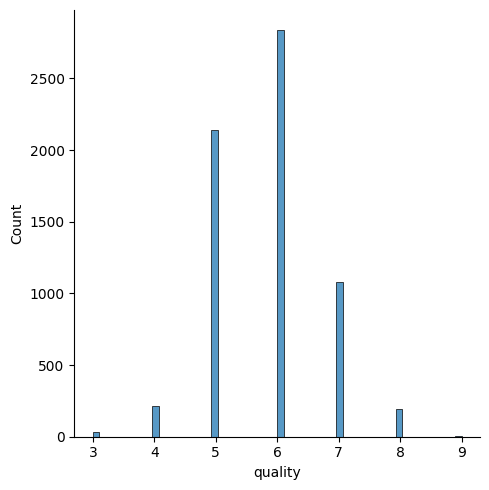

In [31]:
seaborn.displot(data=data["quality"])

We can also compare multiple features in a single graph:

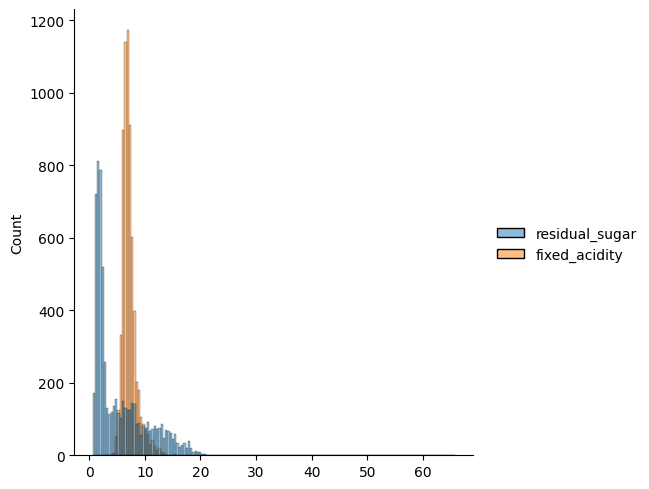

In [35]:
seaborn.displot(data=data[["residual_sugar","fixed_acidity"]])

Let's simplify things by converting quality from a 1-10 scale to a simple boolean. A wine is either of high quality, or it is not. This high_quality feature will be our output feature when we run an inference model.

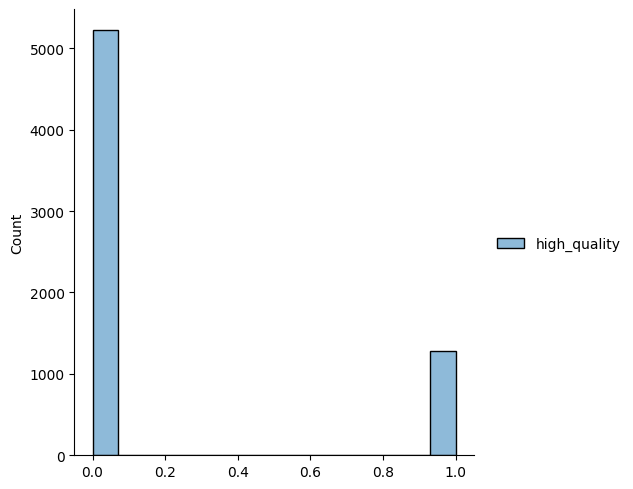

In [67]:
data["high_quality"] = (data.quality >= 7).astype(int) # modify to return an int
data.tail(5)

# Add code below to plot the new high_quality feature on a histogram
seaborn.displot(data=data[["high_quality"]])

The kind of models that we will be using don't handle booleans, so modify your code above so that high_quality is an integer rather than a boolean.

Let's see if there is a quantitative difference between high and low quality wines:

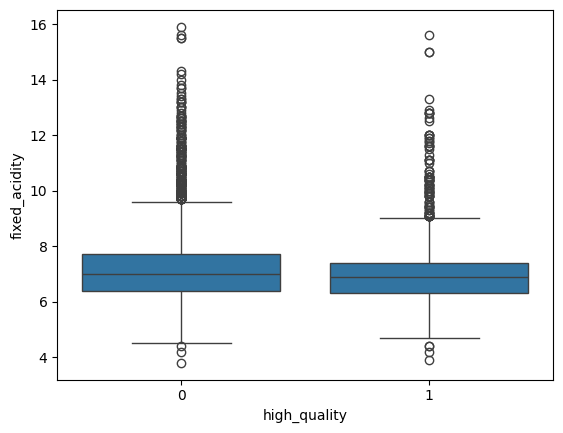

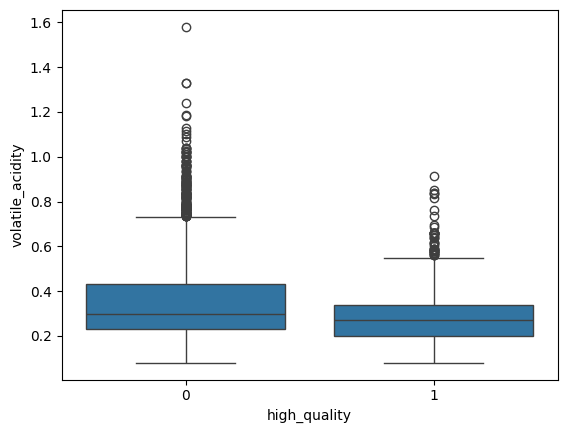

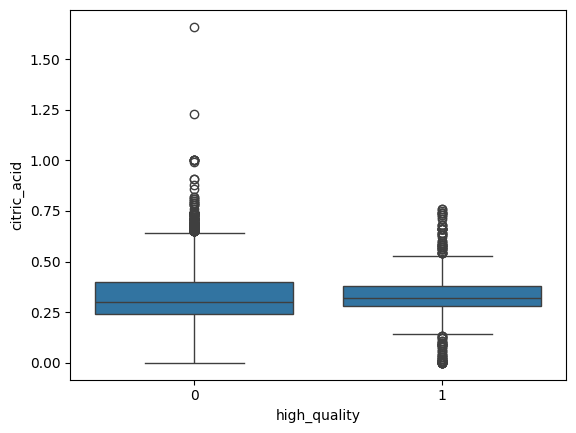

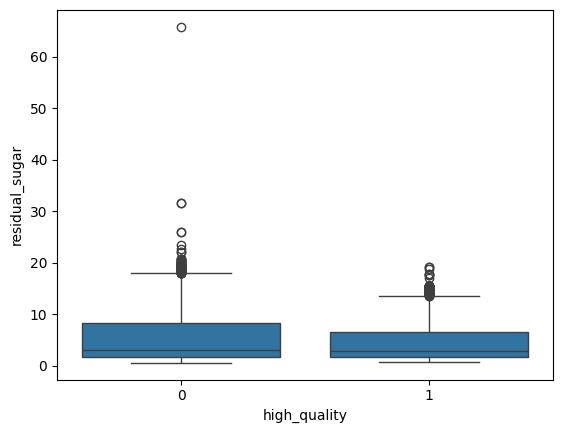

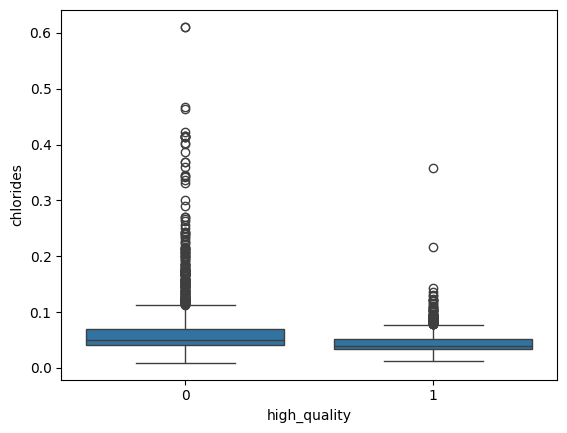

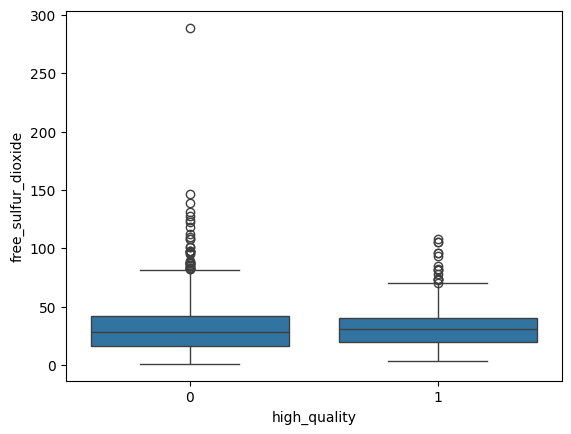

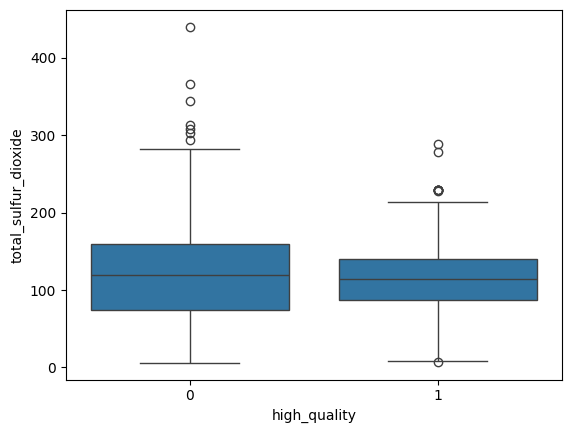

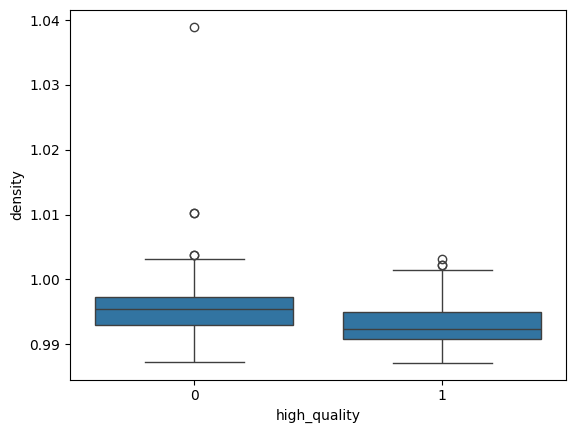

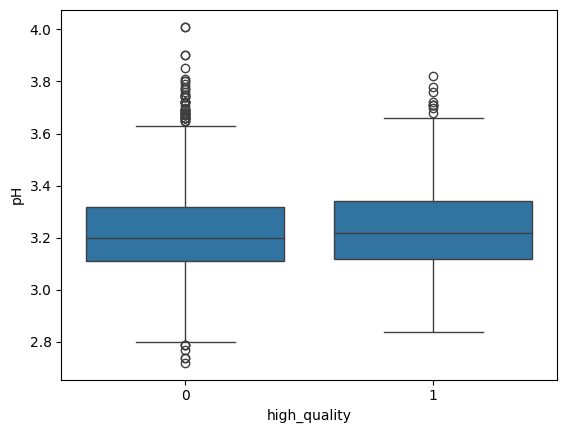

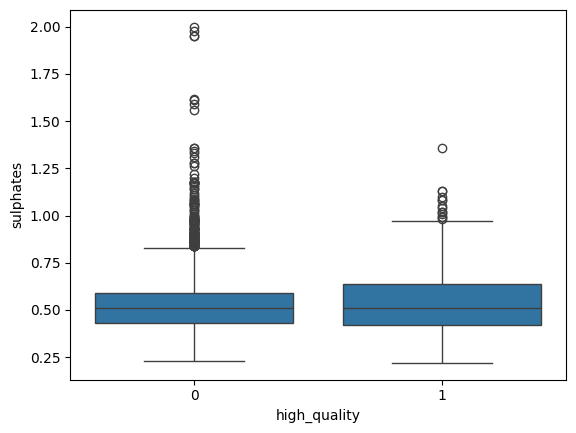

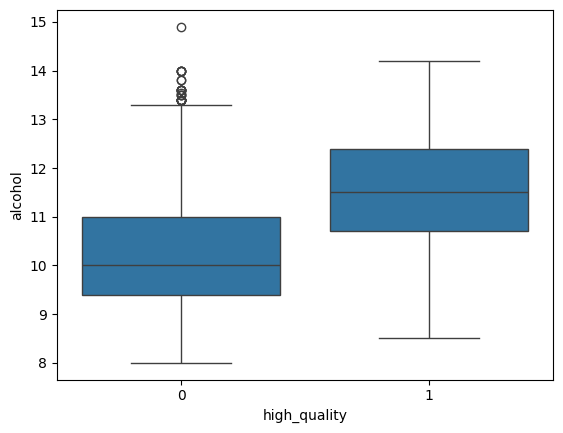

In [82]:
for col in data.columns:
    if col in ["is_red", "quality", "high_quality"]:
        continue # Box plots cannot be used on indicator variables
    seaborn.boxplot(x=data['high_quality'], y=data[col])
    matplotlib.pyplot.show()
  

Finally, let's check if we have any missing values.

In [83]:
data.isna().any()

fixed_acidity           False
volatile_acidity        False
citric_acid             False
residual_sugar          False
chlorides               False
free_sulfur_dioxide     False
total_sulfur_dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
is_red                  False
high_quality            False
dtype: bool

## Prepare dataset for training model <a class="anchor" id="forth-bullet"></a>
We are going to split the input data into 3 sets:

- Train (60% of the dataset used to train the model)
- Validation (20% of the dataset used to tune the hyperparameters)
- Test (20% of the dataset used to report the true performance of the model on an unseen dataset)

In [93]:
def get_trainingdata(data):
    X = data.drop(["high_quality"], axis=1)
    y = data.high_quality

    # Split out the training data
    X_train, X_rem, y_train, y_rem = sklearn.model_selection.train_test_split(X, y, train_size=0.6, random_state=123)

    # Split the remaining data equally into validation and test
    X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_rem, y_rem, test_size=0.5, random_state=123)
    return (X_train,X_val,X_test,y_train,y_val,y_test)

In [94]:
(X_train,X_val,X_test,y_train,y_val,y_test) = get_trainingdata(data)

Use the info methods to explore the training, testing and validation datasets.

In [100]:
X_train.info
y_train.info
# etc

<bound method Series.info of 543     0
4540    0
1429    0
2092    0
1255    0
       ..
3619    0
2461    0
1346    0
1855    0
1983    1
Name: high_quality, Length: 3898, dtype: int64>

## Build a baseline model <a class="anchor" id="fifth-bullet"></a>
Let's use a random forest classifier as a baseline model for our wine quality predictor. This isn't necessarily the fastest model, but is easy to understand, and fast to train, so it's good to use as a baseline. You can learn more about the random forest algorithm here: https://en.wikipedia.org/wiki/Random_forest

We are going to use MLFlow to determine our model's accuracy. This generates two metrics, ROC and AUC, which will help us determine the accuracy of the model, read more about ROC and AUC here: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

In [106]:
experiment_name = "WineQuality"

In [110]:
# check if experiment name already exists
mlflow.set_tracking_uri("http://mlflow:5500")
mlflow.set_experiment(experiment_name)

# enable autologging
mlflow.sklearn.autolog(log_input_examples=True)

MlflowException: API request to http://mlflow:5500/api/2.0/mlflow/experiments/get-by-name failed with exception HTTPConnectionPool(host='mlflow', port=5500): Max retries exceeded with url: /api/2.0/mlflow/experiments/get-by-name?experiment_name=WineQuality (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f8e3d8f0df0>: Failed to establish a new connection: [Errno -2] Name or service not known'))

In [ ]:
def log_featureimportance(model):
    tmpdir = tempfile.mkdtemp()
    filepath = os.path.join(tmpdir, 'feature_importance.json')
    feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
    feature_importances.sort_values('importance', ascending=False).to_json(filepath)
    mlflow.log_artifact(filepath)
    return

Let's create our Random Forest!

In [108]:
class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model

    def predict(self, context, model_input):
        return self.model.predict_proba(model_input)[:,1]

def train_randomforest(X_train,y_train,X_test,y_test):

    with mlflow.start_run(run_name='untuned_random_forest'):
        n_estimators = 10
        model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
        model.fit(X_train, y_train)

        predictions_test = model.predict_proba(X_test)[:,1]
        auc_score = roc_auc_score(y_test, predictions_test)
        mlflow.log_param('n_estimators', n_estimators) #specify the interested parameter/metric
        mlflow.log_metric('auc', auc_score)
        wrappedModel = SklearnModelWrapper(model)

        signature = infer_signature(X_train, wrappedModel.predict(None, X_train))

        conda_env = _mlflow_conda_env(
            additional_conda_deps=None,
            additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
            additional_conda_channels=None,
            )
        mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)
        log_featureimportance(model)
        return model

In [109]:
model = train_randomforest(X_train,y_train,X_test,y_test)

MlflowException: API request to http://mlflow:5500/api/2.0/mlflow/runs/create failed with exception HTTPConnectionPool(host='mlflow', port=5500): Max retries exceeded with url: /api/2.0/mlflow/runs/create (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f8e3da78910>: Failed to establish a new connection: [Errno -2] Name or service not known'))

In [ ]:
# Sanity-check: This should match the AUC logged by MLflow
print(f'AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:,1])}')

In [ ]:
# Sanity-check: This should match the feature importance logged by MLflow
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

## Experiment with a new model (xgboost) <a class="anchor" id="sixth-bullet"></a>
Use the xgboost library to train a more accurate model. Run hyperparameter tuning to train multiple models. As before, the code tracks the performance of each parameter configuration with MLflow.

In [ ]:
search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 50, 100, 10)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
  'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
  'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
  'objective': 'binary:logistic',
  'seed': 123, # Set a seed for deterministic training
}

def train_model(params):

  mlflow.xgboost.autolog()
  with mlflow.start_run(nested=True):
    train = xgb.DMatrix(data=X_train, label=y_train)
    validation = xgb.DMatrix(data=X_val, label=y_val)

    booster = xgb.train(params=params, dtrain=train, num_boost_round=100,\
                        evals=[(validation, "validation")], early_stopping_rounds=50)
    validation_predictions = booster.predict(validation)
    auc_score = roc_auc_score(y_val, validation_predictions)
    mlflow.log_metric('auc', auc_score) #specify the interested parameter/metric

    signature = infer_signature(X_train, booster.predict(train))
    mlflow.xgboost.log_model(booster, "model", signature=signature)

    return {'status': STATUS_OK, 'loss': -1*auc_score, 'booster': booster.attributes()}

with mlflow.start_run(run_name='xgboost_models'):
  best_params = fmin(
    fn=train_model,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
  )

In [ ]:
best_run = mlflow.search_runs(order_by=['metrics.auc DESC']).iloc[0]
best_run_id = best_run["run_id"]
print(f'AUC of Best Run: {best_run["metrics.auc"]}')

In [ ]:
best_run_id

## Predict <a class="anchor" id="seventh-bullet"></a>

In [ ]:
# model = mlflow.pyfunc.load_model(f"models:/TestModelD/production")
model = mlflow.pyfunc.load_model("runs:/" + best_run_id + "/model")

test_predictions = model.predict(X_test)
print(f'AUC: {roc_auc_score(y_test, test_predictions)}')

In [ ]:
from sklearn.metrics import classification_report

class_labels = ['white wine', 'red wine']
test_predictions = np.where(test_predictions>0.5, 1, 0)
print(classification_report(y_test, test_predictions, target_names=class_labels))

In [ ]:
cm = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

In [ ]:
# register the best model
new_model_version = mlflow.register_model(f"runs:/{best_run_id}/model", "WineQuality")

In [ ]:
# # Promote the new model version to Production
# client.transition_model_version_stage(
#   name="TestModelD",
#   version=new_model_version.version,
#   stage="Production"
# )

In [ ]:
# # clean up models
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_registered_model(name="winequality")